# Multi-features classification and  Naive Bayes

In this notebook we will continue to work with the gender classifier based on height. We will use some real(?) data. We will also add weight as additional  feature. This will introduce us to Naive bayes classifier. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,8]

## Height & weight data set

The only data I could find was a [kaggle dataset](https://www.kaggle.com/mustafaali96/weight-height). This data set does not contain any  description of origin but use of inches and pounds suggests an american or english population. The data consists of 10000 points each specifying sex, height and weight of one person.

The data is in popular "coma separated values" (CSV) format. We will use  [pandas library](https://pandas.pydata.org) to read it. Pandas is a very popular library for working with dataframes and series. It would be really worth your time to become acquainted with it. 

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv('../../Data/HeightWeight/weight-height.csv')

The `data` is a [Dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)

In [5]:
type(data)

pandas.core.frame.DataFrame

which is a kind of "table on steroids". We can look at first _n_ rows using `head` method

In [6]:
data.head(n=3)

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856


Another useful method is 

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  10000 non-null  object 
 1   Height  10000 non-null  float64
 2   Weight  10000 non-null  float64
dtypes: float64(2), object(1)
memory usage: 234.5+ KB


and 

In [8]:
data.describe()

,Height,Weight
count,10000.000000,10000.000000
mean,66.367560,161.440357
std,3.847528,32.108439
min,54.263133,64.700127
25%,63.505620,135.818051
50%,66.318070,161.212928
75%,69.174262,187.169525
max,78.998742,269.989699


which gives a more detailed summary of the numerical data contained in the dataframe. Looking at the numbers we can determine that the units are not metric. A good guess would be inches and pounds.

In [9]:
inch = 0.01 * 2.54 # m
pound = 0.453 # kg

In [10]:
data['Height'] = data['Height'] *inch 
data['Weight'] = data['Weight'] *pound

In [11]:
data['Height'] is data.Height

True

Above I have used `data.Height` notation to access the 'Height' column of the data frame. This is "syntactic sugar" and is equivalent to `data['Height']`

In [12]:
data.describe()

,Height,Weight
count,10000.000000,10000.000000
mean,1.685736,73.132482
std,0.097727,14.545123
min,1.378284,29.309157
25%,1.613043,61.525577
50%,1.684479,73.029456
75%,1.757026,84.787795
max,2.006568,122.305333


Now the numbers look realistic. 

We can check that the file contains equal number of women and men data

In [13]:
(data.Gender=='Female').sum()

5000

## Train/Test split

Before we proceed any further we will "do the right thing" and split the data into training and testing set using a function from another very useful library `scikit-learn`. By now you should know why this is  neccesary but let me reiterate this. 

In supervised learning our goal __is not to obtain good classfication on the  labeled data__ we have! We want it to perform well on the  new data that we do not know the labels of. Of course if it cannot classify the training data correctly it will not classify other data correctly as well. But the oposite statement is not true! In principle the classifier could just learn the training examples "by heart" and get a perfect score.  That would be an extreme example of _overfitting_. Overfitting as the name implies means that the classifier has learned to exploite some peculiarities of the training data set and does not _generalise_ well to other data. 

Thus it's the performance on unseen data i.e. generalisation that is our real goal.

That's why we must __always__ keep a portion of our dataset for testings purposes. 

In [14]:
from sklearn.model_selection import  train_test_split

In [15]:
#by fixing the seed we guarantee that we can split the set in same way each time
#this maybe handy for debuging purposes
seed = 77678 
train_data, test_data  = train_test_split(data,test_size=0.25,  random_state=seed, shuffle=True)

In [16]:
print(len(train_data), len(test_data))

7500 2500


Let's see how the data looks like. To visualise a  distribution we will use a _histogram_ of the values. Pandas have a handy built in method that calculates and plots histogram, althought it just delegates the job to numpy and matplotlib. We will create the figure and matplotlib axes ourselfs for more control and pass axes to pandas hist function. 

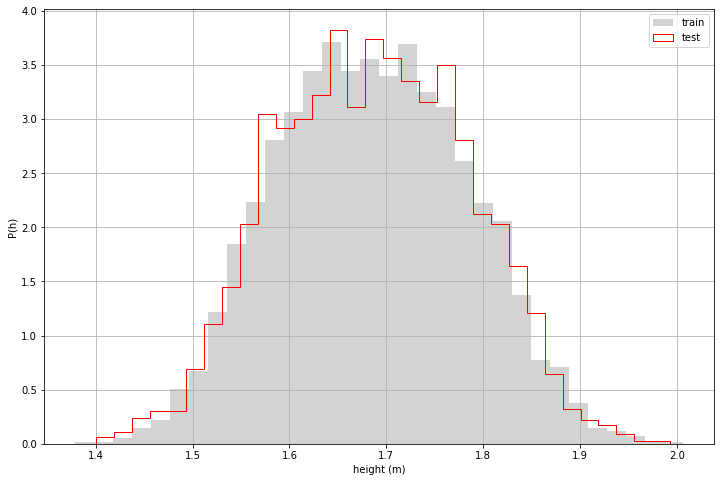

In [17]:
fig, ax = plt.subplots()
ax.set_xlabel("height (m)")
ax.set_ylabel("P(h)")
train_data.Height.hist(bins=32, density=True, ax=ax , label ='train', color='lightgrey');
test_data.Height.hist(bins=32, density=True,  ax=ax, histtype='step', label ='test' , color='red');
plt.legend();

You can look up the description of parameters in [pandas.DataFrame.hist](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html) and [matplotlib.pyplot.hist](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.hist.html) documentation. The one  I have used indicate that the height values should be divided into 32 bins with range of the bins calculated automatically. The `density` parameter set to `True` makes the histogram normalised  so the area under it is  equal to one. This enables an easy comparison with probability density functions and to compare different histograms. 

We have superposed test data histogram to check if the distributions are similar. This is quite important we need the  training set to be representative. 

Accesing one column  returns a [Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) object

In [18]:
type(train_data['Height'])

pandas.core.series.Series

###  Distribution by gender

Going back to the histogram we see that the  distribution looks somewhat "normal-like" but it is rather flat at the top. But actually we do not expect it to be normal, as it contains both women and men data. Let's look at each gender separately.

In [19]:
train_data_F = train_data[train_data.Gender=='Female']
train_data_M = train_data[train_data.Gender=='Male']
print(len(train_data_F), len(train_data_M))

3763 3737


In [20]:
test_data_F = test_data[test_data.Gender=='Female']
test_data_M = test_data[test_data.Gender=='Male']
print(len(test_data_F), len(test_data_M))

1237 1263


In [21]:
# setting colors for consistency throughout the notebook you can subsitute here your favorite "gender colors" :) 
f_color = 'blue'
m_color ='orange'
color = 'grey'

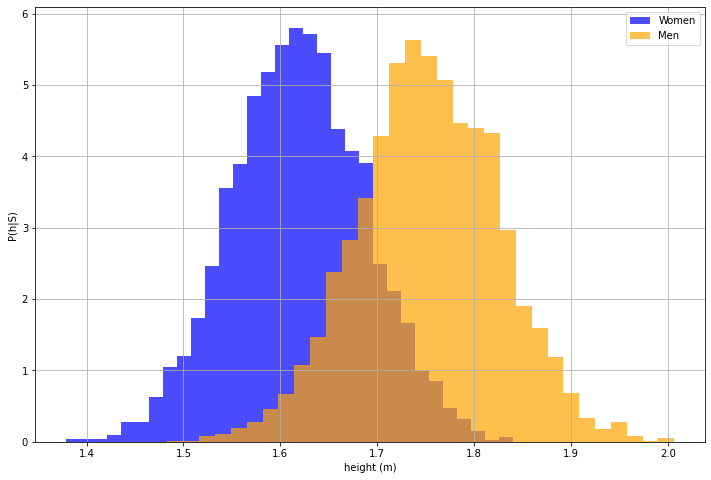

In [22]:
fig, ax = plt.subplots()
ax.set_xlabel("height (m)")
ax.set_ylabel("P(h|S)")
train_data_F.Height.hist(bins=32, density=True, ax=ax , color=f_color, alpha=0.7, label='Women');
train_data_M.Height.hist(bins=32, density=True, ax=ax , color=m_color, alpha=0.7, label='Men');
plt.legend();

It is also a good idea to check again if the train and test data have roughly same distribution as we have alredy done for the joint data. 

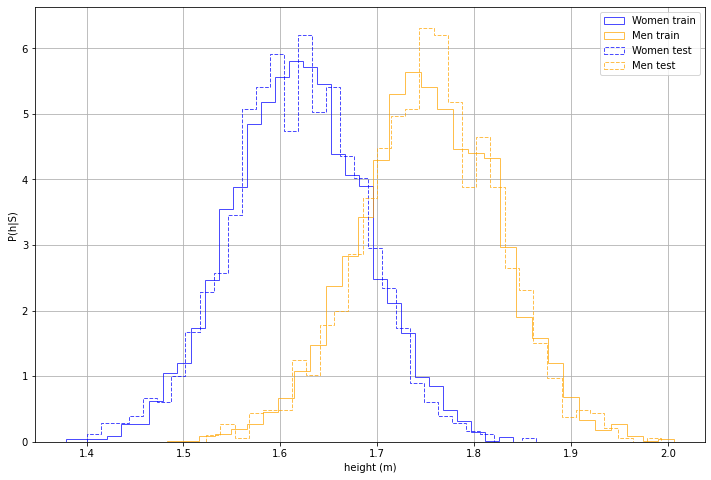

In [23]:
fig, ax = plt.subplots()
ax.set_xlabel("height (m)")
ax.set_ylabel("P(h|S)")
train_data_F.Height.hist(bins=32, density=True, 
                         ax=ax , color=f_color, alpha=0.7, histtype='step', label='Women train');
train_data_M.Height.hist(bins=32, density=True, 
                         ax=ax , color=m_color, alpha=0.7, histtype='step', label="Men train");
test_data_F.Height.hist(bins=32, density=True, 
                         ax=ax , color=f_color, alpha=0.7, histtype='step', linestyle="--", label='Women test');
test_data_M.Height.hist(bins=32, density=True, 
                         ax=ax , color=m_color, alpha=0.7, histtype='step', linestyle="--", label='Men test');
plt.legend();

Histograms look OK but check what happens if we pass the `shuffle=False` parameter to `train_test_split` function. Can you explain what is happening?

## Estimating parameters of the Gaussian distribution

Let's compare those histograms with normal distribution. We will use the `fit` function of the `scipy.stats` normal distribution object. This function calculates the _maximal likelihood_ estimates of the distribution parameters:  mean and standard deviation in this case. 

In [24]:
(mean_F, std_F) = st.norm.fit(train_data_F.Height)
(mean_M, std_M) = st.norm.fit(train_data_M.Height)
print(mean_F, std_F)
print(mean_M, std_M) 

1.618797311072115 0.06848641564905676
1.7529695788781603 0.07321832349657506


We create the `scipy.stats` distribution objects

As you can see those number differ slightly from the ones we have used in the classification notebook so  they clearly correspond to some other population, but it does not matter for our purposes.

In [25]:
pd_F = st.norm(mean_F, std_F)
pd_M = st.norm(mean_M, std_M)

and use them to plot the probability distribution functions over the histograms

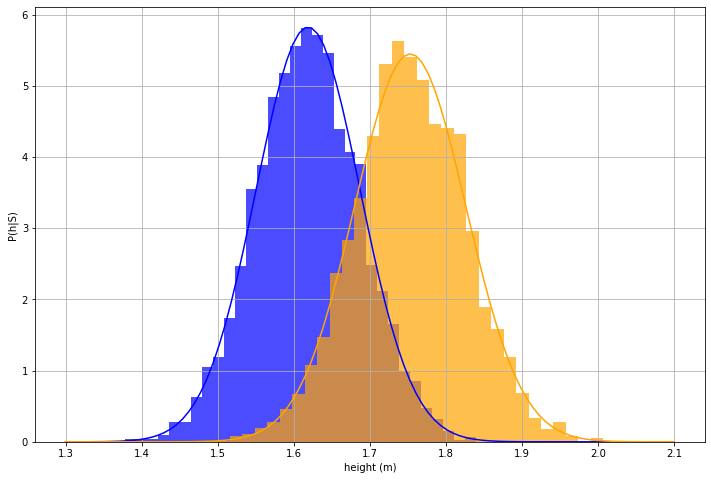

In [26]:
fig, ax = plt.subplots()
ax.set_xlabel("height (m)")
ax.set_ylabel("P(h|S)")
train_data_F.Height.hist(bins=32, density=True, ax=ax , color=f_color, alpha=0.7);
train_data_M.Height.hist(bins=32, density=True, ax=ax , color=m_color, alpha=0.7);
hs =np.linspace(1.3,2.1,100)
ax.plot(hs, pd_F.pdf(hs), c=f_color);
ax.plot(hs, pd_M.pdf(hs), c=m_color);

The results look reasonable and we will assume the normal distribution of heights for each sex throughout this notebook. 

### Maximal likelihood estimator

Now let's open up the black box of the `fit` function. 

The _maximal likelihood_ estimates returned by the `fit` function are the usual

$$\bar{y}\equiv\frac{1}{n}\sum_{i=1}^n y_i$$

and

$$s^2\equiv \overline{y^2}-\bar{y}^2\qquad \bar{y^2}\equiv\frac{1}{n}\sum_{i=1}^n y^2_i$$

#### Caveat

The variance estimator $s^2$ is [_biased_](https://en.wikipedia.org/wiki/Bias_of_an_estimator) and very often its unbiased version 

$$\frac{n}{n-1}s^2$$

is used instead. 

Which version is calculated is controled by the parameter `ddof` of `std` function in numpy or pandas. But please be warned that in numpy the default value of this parameter is zero, correpsonding to $s$ while in pandas this is one and returns the unbiased version. Of course for large $n$ the difference is negligible. 

Those are the basic facts from statistics and I assume you are acquainted with them :) But to refresh your memory I will present here the derivation of the maximal likelihood estimator for normal distribution. 

Given the mean $\mu$ and standard deviation $\sigma$ the  probability of obtaining a sequence of $n$ random  values $y_i$ is

### Likelihood

$$P(y_1,\ldots,y_n|\mu,\sigma) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}}e^{\displaystyle -\frac{(y_i-\mu)^2}{2\sigma^2}}$$

Droping an unimportant constant factor this can rewritten as

$$\sigma^{-n} e^{\displaystyle -\frac{1}{2\sigma^2}\sum_{i=1}^n(y_i-\mu)^2}$$

The sum in the exponential can be expanded as

$$\sum_{i=1}^n(y_i-\mu)^2 
= \sum_{i=1}^n\left( y_i^2-2y_i\mu + \mu^2\right)
=  \sum_{i=1}^n y_i^2 - 2\sum_{i=1}^n y_i\mu +n \mu^2
$$

which is equal to

 $$n \bar{y^2} - 2n\bar{y} \mu +n \mu^2 = n \left(\bar{y^2} - 2\bar{y} \mu + \mu^2\right) $$

which can be further rewritten as

$$\bar{y^2} - 2\bar{y} \mu + \mu^2 
= \bar{y^2} -\bar{y}^2 +\bar{y}^2 - 2\bar{y} \mu + \mu^2
= \bar{y^2} -\bar{y}^2 +\left(\bar{y}-\mu\right)^2 
$$

So finally we obtain

#### Likelihood

$$P(y_1,\ldots,y_n|\mu,\sigma)\propto \sigma^{n} e^{\displaystyle -\frac{n}{2\sigma^2}\left(\bar{y}-\mu\right)^2-\frac{n}{2\sigma^2}s^2}$$

When viewed as function of $y_i$ this is a _sampling distribution_. But we can view this as a function of $\mu$ and $\sigma$. Then this is no longer a probability distribution and is called the _likelihood_. 

### Maximal likelihood

The maximal likelihood estimators are obtained by finding the values of $\mu$ and $\sigma$ that maximise the likelihood. We are looking for the parameters that make our data most probable. 

Because logarithm is a monotonicaly increasing function we can look for the maximum of the logarithm of the likelihood which has a much simpler form

$$\log P(y_1,\ldots,y_n|\mu,\sigma)= -\frac{n}{2}\log\sigma^2-\frac{n}{2\sigma^2}\left(\bar{y}-\mu\right)^2-\frac{n}{2\sigma^2}s^2 +C$$

Differentiating with repect to $\mu$ we obtain equation
:

$$\frac{n}{2\sigma^2}\left(\bar{y}-\mu\right)=0$$

with an obvious solution 

$$\mu=\bar{y}$$

Differentiatig with respect to $\sigma^2$ gives:

$$-\frac{n}{2\sigma^2} +\frac{n}{2\sigma^4}(\bar{y}-\mu)^2+\frac{n}{2\sigma^4}s^2=0$$

After inserting the solution for $\mu$ we get

$$\frac{n}{2\sigma^2} =\frac{n}{2\sigma^4}s^2$$

with solution

$$\sigma^2 = s^2$$

### Classifier

The classifier can be now constructed in the same way as in previous lecture. To make this notebook self contained I will repeat those calculations but wrap them up in couple of functions. 

In [27]:
def make_pdf_P_cond(labels, data):
    """Takes labels (0,1) and a single feature and returns the conditional 
    probability distribution function of the   positive label given the feature assuming
    normal distribution of the  feature values.
    """
    
    positives = data[labels==1]
    negatives = data[labels==0]
    
    pdf_cond_P = st.norm(*st.norm.fit(positives)).pdf
    pdf_cond_N = st.norm(*st.norm.fit(negatives)).pdf
    
    P_P = labels.mean()
    P_N = 1-P_P
    
    def pdf(x):
        return pdf_cond_P(x)*P_P/(pdf_cond_P(x)*P_P+pdf_cond_N(x)*P_N)
        
    return pdf

In [28]:
pdf_F_cond_h  = make_pdf_P_cond(train_data.Gender=='Female', train_data.Height)

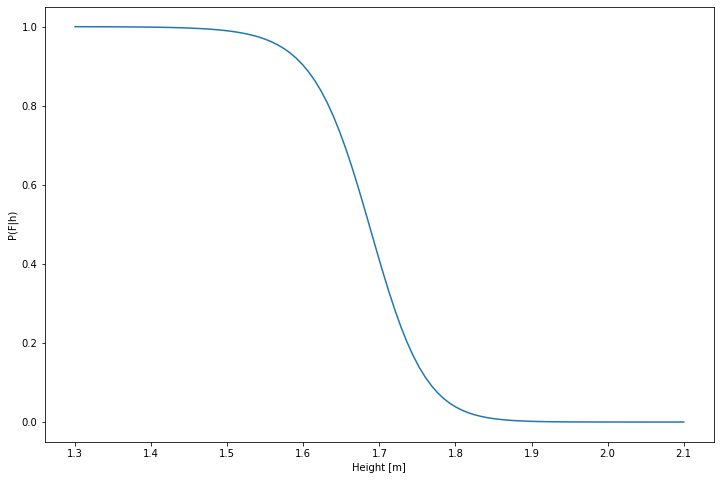

In [29]:
fig, ax = plt.subplots()
hs =np.linspace(1.3, 2.1,100)
ax.plot(hs, pdf_F_cond_h(hs));
ax.set_xlabel("Height [m]");
ax.set_ylabel("P(F|h)");

In [30]:
from scipy.optimize import fsolve
threshold = fsolve(lambda h: pdf_F_cond_h(h)-0.5, 1.7)
print(threshold)

[1.68639553]


In [31]:
from collections import namedtuple

In [32]:
ConfusionMatrix = namedtuple('ConfusionMatrix',['TP','FP', 'FN', 'TN'])

def confusion_matrix(labels, probability, th=0.5):
    """
    Calculates the confusion matrix from true labels and predicted probabilities
    
    Parameters:
    labels -- 
    """
    p = (labels == 1).sum()
    n = (labels == 0).sum()
    
    pred = (probability >= th)
    fp = (pred > labels).sum()
    fn = (pred < labels).sum()
    
    return ConfusionMatrix(p-fn, fp, fn, n-fp)

def rates(cm):
    P = cm.TP + cm.FN
    N = cm.FP + cm.TN
    
    tpr = cm.TP/P
    fpr = cm.FP/N
    fnr = cm.FN/P
    tnr = cm.TN/N
    
    return tpr, fpr, fnr, tnr
    
def accuracy(cm):    
    P = cm.TP + cm.FN
    N = cm.FP + cm.TN
    
    return (cm.TP+cm.TN)/(P+N)

def precission(cm):
    return (cm.TP)/(cm.TP+cm.FP)
    

def describe(cm):
    P = cm.TP + cm.FN
    N = cm.FP + cm.TN
    
    tpr, fpr,fnr, tnr = rates(cm)
    
    print("Total = {:d} (P = {:d}, N = {:d})".format(P+N, P,N))
    print("TPR = {:5.3f} FPR = {:5.3f}".format(tpr,fpr))
    print("FNR = {:5.3f} TNR = {:5.3f}".format(fnr,tnr))
    
    print("Accuracy  = {:5.3f}".format(accuracy(cm)) )
    print("Precision = {:5.3f}".format(precission(cm)) )

In [33]:
describe(confusion_matrix(train_data.Gender=='Female', pdf_F_cond_h(train_data.Height)) )

Total = 7500 (P = 3763, N = 3737)
TPR = 0.836 FPR = 0.180
FNR = 0.164 TNR = 0.820
Accuracy  = 0.828
Precision = 0.824


In [34]:
cm_test = confusion_matrix(test_data.Gender=='Female', pdf_F_cond_h(test_data.Height))
tpr, fpr,_,_=rates(cm_test)
describe(cm_test )

Total = 2500 (P = 1237, N = 1263)
TPR = 0.850 FPR = 0.162
FNR = 0.150 TNR = 0.838
Accuracy  = 0.844
Precision = 0.837


In [35]:
from sklearn.metrics import roc_auc_score, roc_curve

In [36]:
fprs, tprs, thds = roc_curve(test_data.Gender=='Female', pdf_F_cond_h(test_data.Height))
auc = roc_auc_score(test_data.Gender=='Female', pdf_F_cond_h(test_data.Height))

In [37]:
def roc_plot(plt, title ='ROC', figsize=[8,8]):
    """
    Returns pyplot figure and axes object designed for plotting ROC curve. 
    
    It sets aspect ratio to one, labels the axes and sets the title.
    
    Parameters:
    plt : pyplot module
    title : the title of the plot
    figsize : Figure size in inches 
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect(1)
    ax.set_xlabel('FPR');
    ax.set_ylabel('TPR');
    ax.set_title(title)
    ax.plot([0,1,1,0,0],[0,0,1,1,0], '-', color='grey', linewidth=1)
    return fig,ax

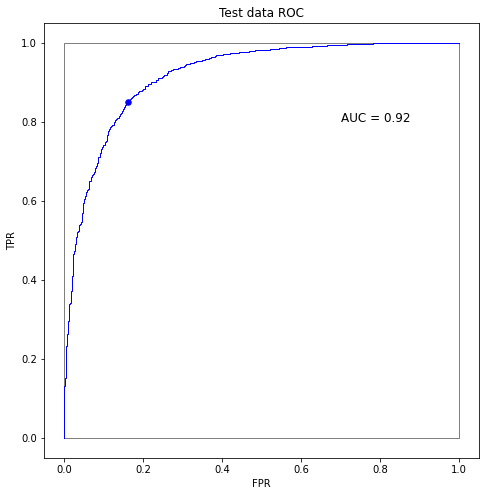

In [38]:
fig, ax = roc_plot(plt, 'Test data ROC')
roc = ax.plot(fprs,tprs, color='blue', linewidth=1);
ax.scatter([fpr],[tpr],s = 30, edgecolor='blue', zorder=5, facecolor='blue');
ax.text(0.7, 0.8, "AUC = {:4.2f}".format(auc), fontsize=12);

This plot looks slightly worse then the one  we did last time, but that's becase we have only 2500 data points instead of 100000 that we have generated by Monte-Carlo.  

Let's finish with some graphical iterpretation.

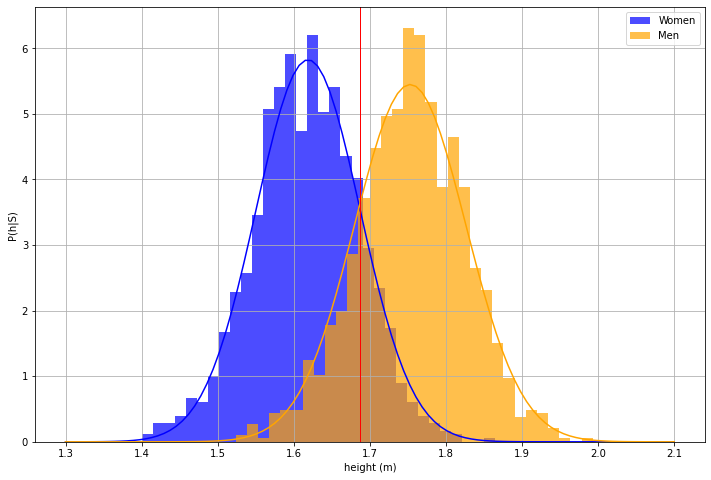

In [39]:
fig, ax = plt.subplots()
ax.set_xlabel("height (m)")
ax.set_ylabel("P(h|S)")
test_data_F.Height.hist(bins=32, density=True, ax=ax , color=f_color, alpha=0.7, label='Women');
test_data_M.Height.hist(bins=32, density=True, ax=ax , color=m_color, alpha=0.7, label='Men');
hs =np.linspace(1.3,2.1,100)
ax.plot(hs, pd_F.pdf(hs), c=f_color);
ax.plot(hs, pd_M.pdf(hs), c=m_color);
plt.axvline(threshold, c='red', linewidth = 1);
plt.legend();

Those are the histograms of the test data with distributions derived from the traning data. The red vertical line marks the threshold for classfication. Blue on the left are true positives, orange on the left are false positives, blue on the right are false negatives and orange on right are true negatives. 

# More features

Using one feature is not very realistic. Normally we would use tens, hundreds or even thousands of different features. Each feature potentially adds information and increases the quality of the classifier. In our data set we have one more feature that we can use: weight. 

Visualising multidimensional data is hard. We can start by looking at them one by one. We have already looked at the distribution of heights so now we will plot the distribution of weights. 

### Weight

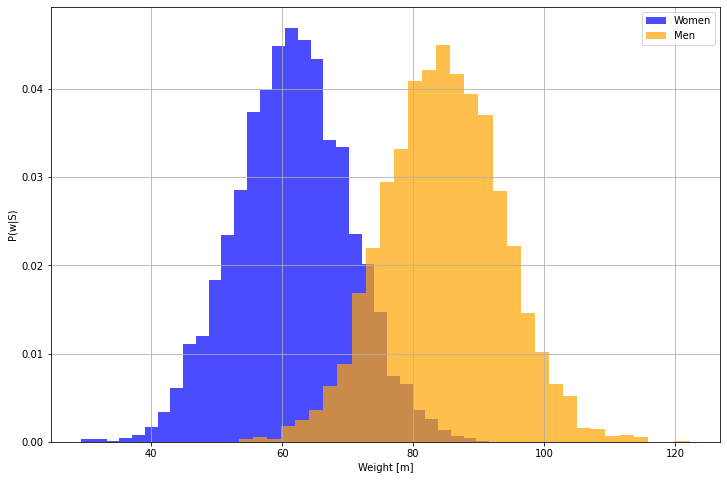

In [40]:
fig, ax = plt.subplots()
ax.set_xlabel("Weight [m]")
ax.set_ylabel("P(w|S)")
train_data_F.Weight.hist(bins=32, density=True, ax=ax , color=f_color, alpha=0.7, label='Women');
train_data_M.Weight.hist(bins=32, density=True, ax=ax , color=m_color, alpha=0.7, label='Men');
plt.legend();

The distribution of weights by gender looks reasonably normal, but what we need is the join distribution of height and weight.

$$P(h,w|S)$$

This we can visualize using a _scatter_ plot 

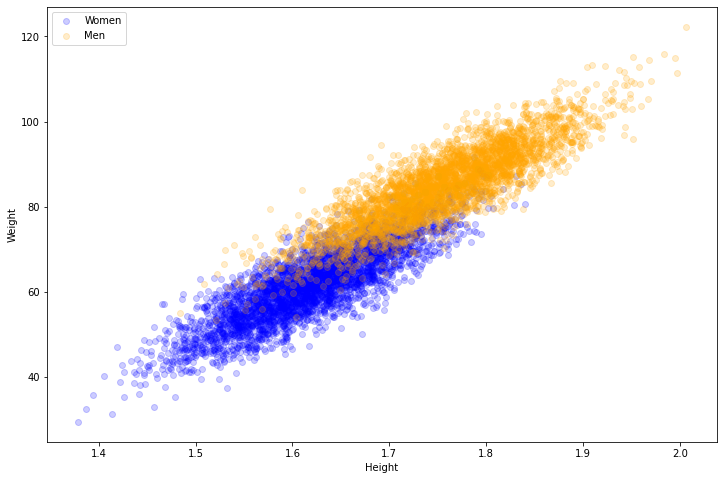

In [41]:
plt.scatter(train_data_F.Height, train_data_F.Weight, alpha=0.2, c = f_color, label='Women');
plt.scatter(train_data_M.Height, train_data_M.Weight, alpha=0.2, c = m_color, label='Men');
plt.xlabel('Height')
plt.ylabel('Weight');
plt.legend();

Unfortunatelly this plot quickly saturates and it is hard to judge the density of points in different regions (you can try to play with the alpha parameter). 

We can use 2D histograms, but then it is not possible to separate data for women and men on the same plot. Histogram below displays all the data together. 

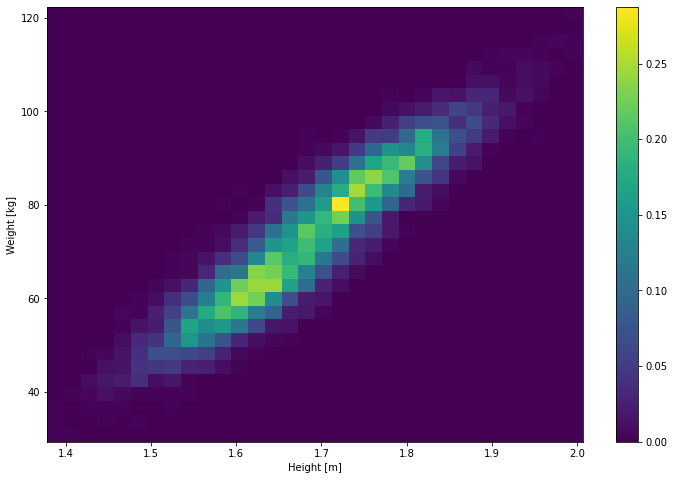

In [42]:
hb = plt.hist2d(train_data['Height'], train_data['Weight'], bins=32, density=True);
plt.xlabel('Height [m]')
plt.ylabel('Weight [kg]')
plt.colorbar(hb[3]);

Sometimes we can get a nicer picture with hexagonal bins:

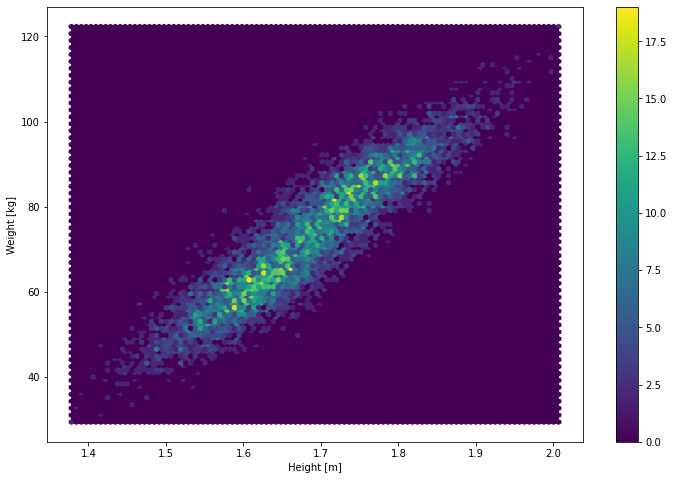

In [43]:
hb = plt.hexbin(train_data['Height'], train_data['Weight'], bins=20);
plt.xlabel('Height [m]')
plt.ylabel('Weight [kg]')
plt.colorbar(hb);

One way to proceed would be to try to model the joint distribution of  height and weight for each sex as a two dimensional normal distribution. Another, and that is the one we will pursue here is to model them independently. 

## (In)dependence

In order to do that we require the features to be at least approximately independent. That is obviously not the case for height and weight. Common sense tells us that taller persons will be usually heavier. That is borne out the plots above as the points cluster around the diagonal. We can check this by calculating the _correlation_ between the  height and weight.

Correlation can be easily calculated using [pandas.Series.corr](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.corr.html) or [numpy.corrcoef](https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html) build in functions. 

In [44]:
train_data[['Height', 'Weight']].corr()

,Height,Weight
Height,1.00000,0.92372
Weight,0.92372,1.00000


This gives us a symmetric correlation matrix. On the diagonal we always have 1.0. The off diagonal  entries correspond to correlation between two variables. As expected height and weight are highly correlated (the maximal value of correlation  coefficient is one). 

Let's look separately at each sex

In [45]:
train_data_F = train_data.loc[data['Gender']=='Female']
train_data_M   = train_data.loc[data['Gender']=='Male']

In [46]:
train_data_F[['Height', 'Weight']].corr()

,Height,Weight
Height,1.00000,0.84857
Weight,0.84857,1.00000


In [47]:
train_data_M[['Height', 'Weight']].corr()

,Height,Weight
Height,1.000000,0.863865
Weight,0.863865,1.000000


### BMI 

In order to  reduce the correlations we will use the [Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index) instead of weight. Its idea was exactly to provide a height independent characterisation of persons weight. 

In [48]:
data['BMI'] = data['Weight']/data['Height']**2

Because we have changed the data we have to redo the train test split. Using same seed will gives us exactly same sets as before which will be convenient for comparison. 

In [49]:
train_data, test_data  = train_test_split(data,test_size=0.25, random_state=seed)

In [50]:
from sklearn.linear_model import LinearRegression

In [51]:
reg = LinearRegression().fit(train_data['Height'].values.reshape(-1,1), train_data['BMI'].values)

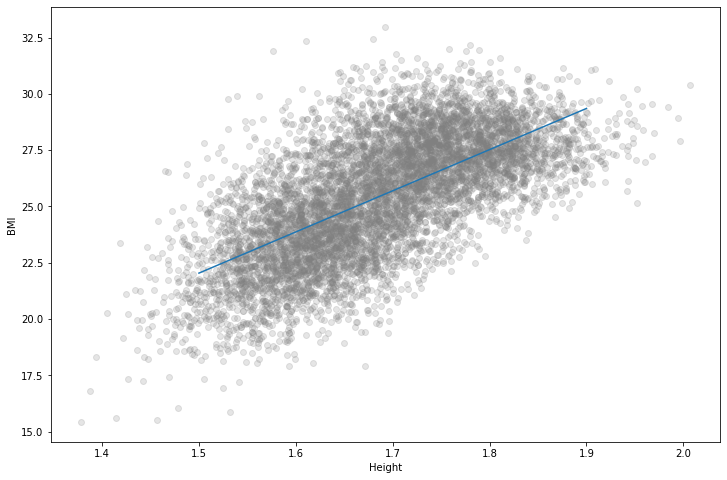

In [52]:
hs = np.linspace(1.5,1.9)
plt.scatter(train_data['Height'],train_data['BMI'], alpha=0.2, c=color);
plt.xlabel('Height')
plt.ylabel('BMI');
plt.plot(hs, reg.predict(hs.reshape(-1,1)));

The scatter plot  still indicates rather strong correlation, but correlation coefficient is actually lower

In [53]:
train_data[['Height', 'BMI']].corr()

,Height,BMI
Height,1.000000,0.663609
BMI,0.663609,1.000000


In [54]:
train_data_F = train_data.loc[data['Gender']=='Female']
train_data_M   = train_data.loc[data['Gender']=='Male']

In [55]:
reg_F = LinearRegression().fit(train_data_F['Height'].values.reshape(-1,1), train_data_F['BMI'].values)
reg_M = LinearRegression().fit(train_data_M['Height'].values.reshape(-1,1), train_data_M['BMI'].values)

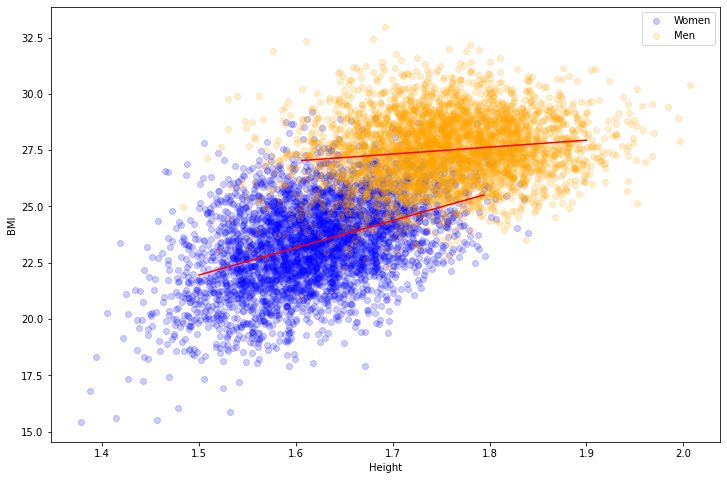

In [56]:
plt.scatter(train_data_F['Height'],train_data_F['BMI'], alpha=0.2, c = f_color, label='Women');
plt.scatter(train_data_M['Height'], train_data_M['BMI'], alpha=0.2, c = m_color, label='Men');
plt.plot(hs[hs>1.6],reg_M.predict(hs[hs>1.6].reshape(-1,1)), color='red')
plt.plot(hs[hs<1.8],reg_F.predict(hs[hs<1.8].reshape(-1,1)), color='red')
plt.xlabel('Height')
plt.ylabel('BMI');
plt.legend();

Now each cluster look less correlated, especially men. And indeed the correlation coefficients are lower  for each sex

In [57]:
train_data_F[['Height', 'BMI']].corr()

,Height,BMI
Height,1.000000,0.424089
BMI,0.424089,1.000000


In [58]:
train_data_M[['Height', 'BMI']].corr()

,Height,BMI
Height,1.000000,0.150195
BMI,0.150195,1.000000


### Conditional independence

What we have done  was to check for _conditional independence_. Two random variables $X$ and $Y$ are idenpendent conditioned on third variable $Z$ if 

$$P(X=x,Y=y|Z=z)=P(Y=y|Z=z)P(Y=y|Z=z)$$

Important point to note here is that two variables can be dependent on each other but be independent when coditioned on third variable.  This happens when _e.g._ both variables $X$ and $Y$ depend on $Z$ but not on each other.


 

Take for example the number of ice creams sold and number of men in t-shirts on the street. Those variables are most probably correlated as they both depend on the air temperature. If we see lots of men in t-shirts it is probable that it is a nice warm day and consequently the ice creams sales are higher. If we condition on temperature that is  look only at the days with same air temperature we will probably find  that number of ice cream sold is idenpendent of number of men in t-shirts. 

## Naive Bayes classifier

We have not established that the height and BMI are independent conditioned on sex, but we how shown that that dependence is significantly reduced. This is a rationale behind _Naive Bayes_ classifier.

Let's assume that we have $k$ features $X_i$ that we want to use to predict class $C$. Approach that we have used so far would require knowledge of the join probability

$$P(X_1=x_1,\ldots,X_k=k_k|C=c)$$ 

In Naive Bayes we __assume__ that those features are independent conditionned on class random variable $C$

$$P(X_1=x_1,\ldots,X_k=x_k|C=c)=P(X_1=x_1|C=c)\cdots P(X_k=x_k|C=c)$$ 

and so 

$$P(C=c|X_1=x_1,\ldots,X_k=x_k)= \frac{P(X_1=x_1|C=c)\cdots P(X_k=x_k|C=c) P(C=c)}{\sum_c P(X_1=x_1|C=c)\cdots P(X_k=x_k|C=c) P(C=c)}$$ 

In our example this translates to (I have used $B$ and $b$ to denote BMI random variable and its value)

$$P(S=f|H=h, B = b) = \frac{P(H=h|S=f)P(B=b|S=f)P(S=f)}
{P(H=h|S=f)P(B=b|S=f)P(S=f)+
P(H=h|S=m)P(B=b|S=m)P(S=m)}$$

We know that the height distribution for each sex can be approximated as normal. We have to check if this is also true for BMI.

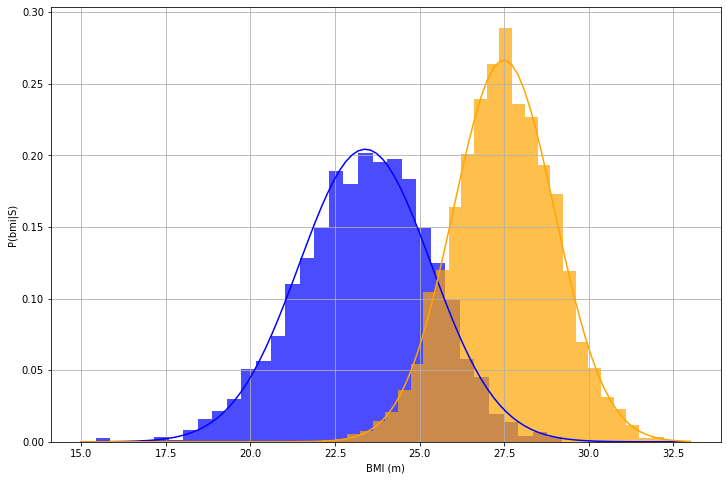

In [59]:
fig, ax = plt.subplots()
ax.set_xlabel("BMI (m)")
ax.set_ylabel("P(bmi|S)")
train_data_F.BMI.hist(bins=32, density=True, ax=ax , color=f_color, alpha=0.7);
train_data_M.BMI.hist(bins=32, density=True, ax=ax , color=m_color, alpha=0.7);
bmis =np.linspace(15,33,100)
pdf_bmi_F = st.norm(*st.norm.fit(train_data_F.BMI)).pdf
ax.plot(bmis, pdf_bmi_F(bmis), c=f_color);
pdf_bmi_M = st.norm(*st.norm.fit(train_data_M.BMI)).pdf
ax.plot(bmis, pdf_bmi_M(bmis), c=m_color);

This looks resonable so we will stick with this choice. The function below  constructs the  $P(S=f|H=h, B=b)$ function  from height and BMI data

In [60]:
def make_pdf_P_cond_NB(labels, h, bmi ):
    
    positives = labels==1
    negatives = labels==0
    
    pdf_h_P = st.norm(*st.norm.fit(h[positives])).pdf
    pdf_h_N = st.norm(*st.norm.fit(h[negatives])).pdf 
    
    pdf_bmi_P = st.norm(*st.norm.fit(bmi[positives])).pdf
    pdf_bmi_N = st.norm(*st.norm.fit(bmi[negatives])).pdf                  
                      
    
    P_P = labels.mean()
    P_N = 1-P_P
    
    def pdf(ha, bmia):
        p_prod = pdf_h_P(ha)*pdf_bmi_P(bmia)*P_P
        n_prod = pdf_h_N(ha)*pdf_bmi_N(bmia)*P_N
        
        
        return p_prod/(p_prod +n_prod)
        
    return pdf

In [61]:
nb_prob = make_pdf_P_cond_NB(train_data['Gender']=='Female', train_data.Height, train_data.BMI)

In [62]:
nb_cm  = confusion_matrix(test_data.Gender=='Female', nb_prob(test_data.Height, test_data.BMI) )
nb_tpr, nb_fpr, _,_ = rates(nb_cm)

In [63]:
describe(nb_cm)

Total = 2500 (P = 1237, N = 1263)
TPR = 0.900 FPR = 0.078
FNR = 0.100 TNR = 0.922
Accuracy  = 0.911
Precision = 0.919


In [66]:
nb_fprs, nb_tprs, nb_thds = roc_curve(test_data.Gender=='Female', nb_prob(test_data.Height, test_data.BMI) )
nb_auc = roc_auc_score(test_data.Gender=='Female', nb_prob(test_data.Height, test_data.BMI) )

TypeError: roc_plot() missing 1 required positional argument: 'plt'

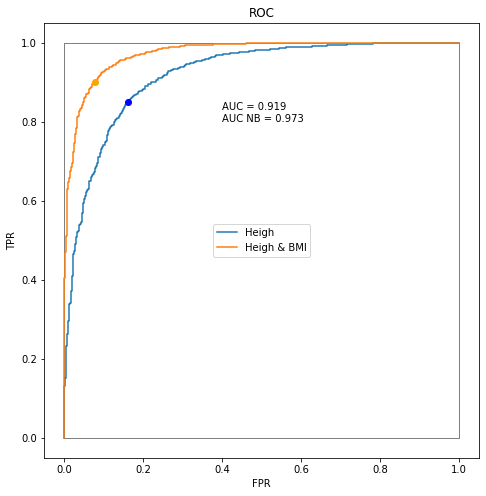

In [65]:
fig,ax = roc_plot(plt)
ax.plot(fprs, tprs, label='Heigh')
ax.scatter([fpr],[tpr], color='blue', zorder = 5)
ax.plot(nb_fprs, nb_tprs,  label = "Heigh & BMI")
ax.scatter([nb_fpr],[nb_tpr], color='orange', zorder = 5)
ax.text(0.4,0.8,"AUC = {:.3f}\nAUC NB = {:.3f}".format(auc, nb_auc))
ax.legend();

As we can see adding weight  feature in form of the BMI substantially increased the quality of our classifier. 